In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [4]:
#Metric Functions
def PearsonCoefficient(X, Y):
    r = np.sum((X - np.average(X)) * (Y - np.average(Y))) / math.sqrt(np.sum((X - np.average(X)) ** 2) * np.sum((Y - np.average(Y)) ** 2))
    return r

def MAPE(X,Y):
    mape = np.average(abs(X - Y) / Y) * 100
    return mape

In [22]:
#Load Dataset
data=pd.read_csv('BF3_Affinity_Dataset.csv').iloc[:,2:]

In [23]:
#Descriptor Type Analysis
discrete=['MW','AMW','Sv','Se','Sp','Ss','Mv','Me','Mp','Ms','ARR','RBF','Ui','Hy','AMR','TPSA(NO)','TPSA(Tot)','MLOGP','ALOGP']
continuous=[]
for x in data.columns[2:]:
    if x not in discrete:
        continuous.append(x)
target=data['BF3_Affinity(kJ/mol)']

discrete_r=[]
for i in discrete:
    discrete_r.append(PearsonCoefficient(data[i],target))
continuous_r=[]
for i in continuous:
    continuous_r.append(PearsonCoefficient(data[i],target))
print(np.mean(np.absolute(discrete_r)),np.std(np.absolute(discrete_r)),max(np.absolute(discrete_r)),min(np.absolute(discrete_r)))
print(np.mean(np.absolute(continuous_r)),np.std(np.absolute(continuous_r)),max(np.absolute(continuous_r)),min(np.absolute(continuous_r)))
print(np.mean(np.absolute(discrete_r+continuous_r)),np.std(np.absolute(discrete_r+continuous_r)),
     max(np.absolute(discrete_r+continuous_r)),min(np.absolute(discrete_r+continuous_r)))

0.15626052406610194 0.0901388553386422 0.4106347070359237 0.0069313709770218454
0.114677574119428 0.10051542620212812 0.49451387963455057 0.00023651620434281883
0.11949511100349385 0.10025603214780827 0.49451387963455057 0.00023651620434281883


In [24]:
#Split Dataset
def binvalue(data,target,split_ratio):
    a=np.sort(data[target])
    variables=[a[0]-abs(a[0])/100]
    for i in range (1,split_ratio):
        variables.append(a[int(len(a)*i/split_ratio)])
    variables.append(np.inf)
    return variables

sub=pd.cut(data['BF3_Affinity(kJ/mol)'],bins=binvalue(data,'BF3_Affinity(kJ/mol)',5),labels=np.arange(1,6,1))
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=22)
for train_index,test_index in split.split(data,sub):
    train=data.loc[train_index]
    test=data.loc[test_index]

y,x=data['BF3_Affinity(kJ/mol)'],data[train.columns[2:]]
y_train,x_train=train['BF3_Affinity(kJ/mol)'],train[train.columns[2:]]
y_test ,x_test = test['BF3_Affinity(kJ/mol)'], test[train.columns[2:]]
print(np.mean(y),np.std(y))

87.62888888888891 23.855370879910122


In [25]:
#Gradient Boosting Testing
model=GradientBoostingRegressor(n_estimators=120,
                                learning_rate=0.1,
                                max_depth=4,
                                random_state=22)
model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
gb_y_test_pred=model.predict(x_test)
gb_fi=model.feature_importances_

print('Train set:\tR:',"{:.5f}".format(PearsonCoefficient(y_train,y_train_pred)),
      '\tMAPE:',"{:.5f}".format(MAPE(y_train,y_train_pred)))
print('Test set:\tR:',"{:.5f}".format(PearsonCoefficient(y_test,gb_y_test_pred)),
      '\tMAPE:',"{:.5f}".format(MAPE(y_test,gb_y_test_pred)))

rmse_cv_results, r_cv_results = list(), list()

kfold = RepeatedKFold(n_splits=5, n_repeats=6, random_state=22)
scoring = {'rmse':'neg_root_mean_squared_error',
           'pr_score': make_scorer(PearsonCoefficient),
          'mape':make_scorer(MAPE)}


this_cv_scores = cross_validate(model, x, y, cv=kfold,
                                scoring=scoring, n_jobs=-1,
                                error_score='raise',
                                return_estimator=True)

gb_rmse=this_cv_scores['test_rmse']
gb_r=this_cv_scores['test_pr_score']
gb_mape=this_cv_scores['test_mape']
print(np.mean(gb_rmse),np.std(gb_rmse))
print(np.mean(gb_r),np.std(gb_r))

Train set:	R: 0.99752 	MAPE: 1.73224
Test set:	R: 0.85753 	MAPE: 7.94533
-9.706784079520236 1.6708743340063226
0.9106332005948666 0.036209883764981916


In [26]:
#Ridge Testing
model=Ridge()
model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
ridge_y_test_pred=model.predict(x_test)

print('Train set:\tR:',"{:.5f}".format(PearsonCoefficient(y_train,y_train_pred)),
      '\tMAPE:',"{:.5f}".format(MAPE(y_train,y_train_pred)))
print('Test set:\tR:',"{:.5f}".format(PearsonCoefficient(y_test,ridge_y_test_pred)),
      '\tMAPE:',"{:.5f}".format(MAPE(y_test,ridge_y_test_pred)))
rmse_cv_results, r_cv_results = list(), list()

kfold = RepeatedKFold(n_splits=5, n_repeats=6, random_state=22)
scoring = {'rmse':'neg_root_mean_squared_error',
           'pr_score': make_scorer(PearsonCoefficient),
          'mape':make_scorer(MAPE)}


this_cv_scores = cross_validate(model, x, y, cv=kfold,
                                scoring=scoring, n_jobs=-1,
                                error_score='raise',
                                return_estimator=True)

ridge_rmse=this_cv_scores['test_rmse']
ridge_r=this_cv_scores['test_pr_score']
ridge_mape=this_cv_scores['test_mape']
print(np.mean(ridge_rmse),np.std(ridge_rmse))
print(np.mean(ridge_r),np.std(ridge_r))

Train set:	R: 0.97717 	MAPE: 4.32561
Test set:	R: 0.90454 	MAPE: 7.29083
-8.862030158919238 1.2544808647363481
0.9302559325769127 0.01704907158209138


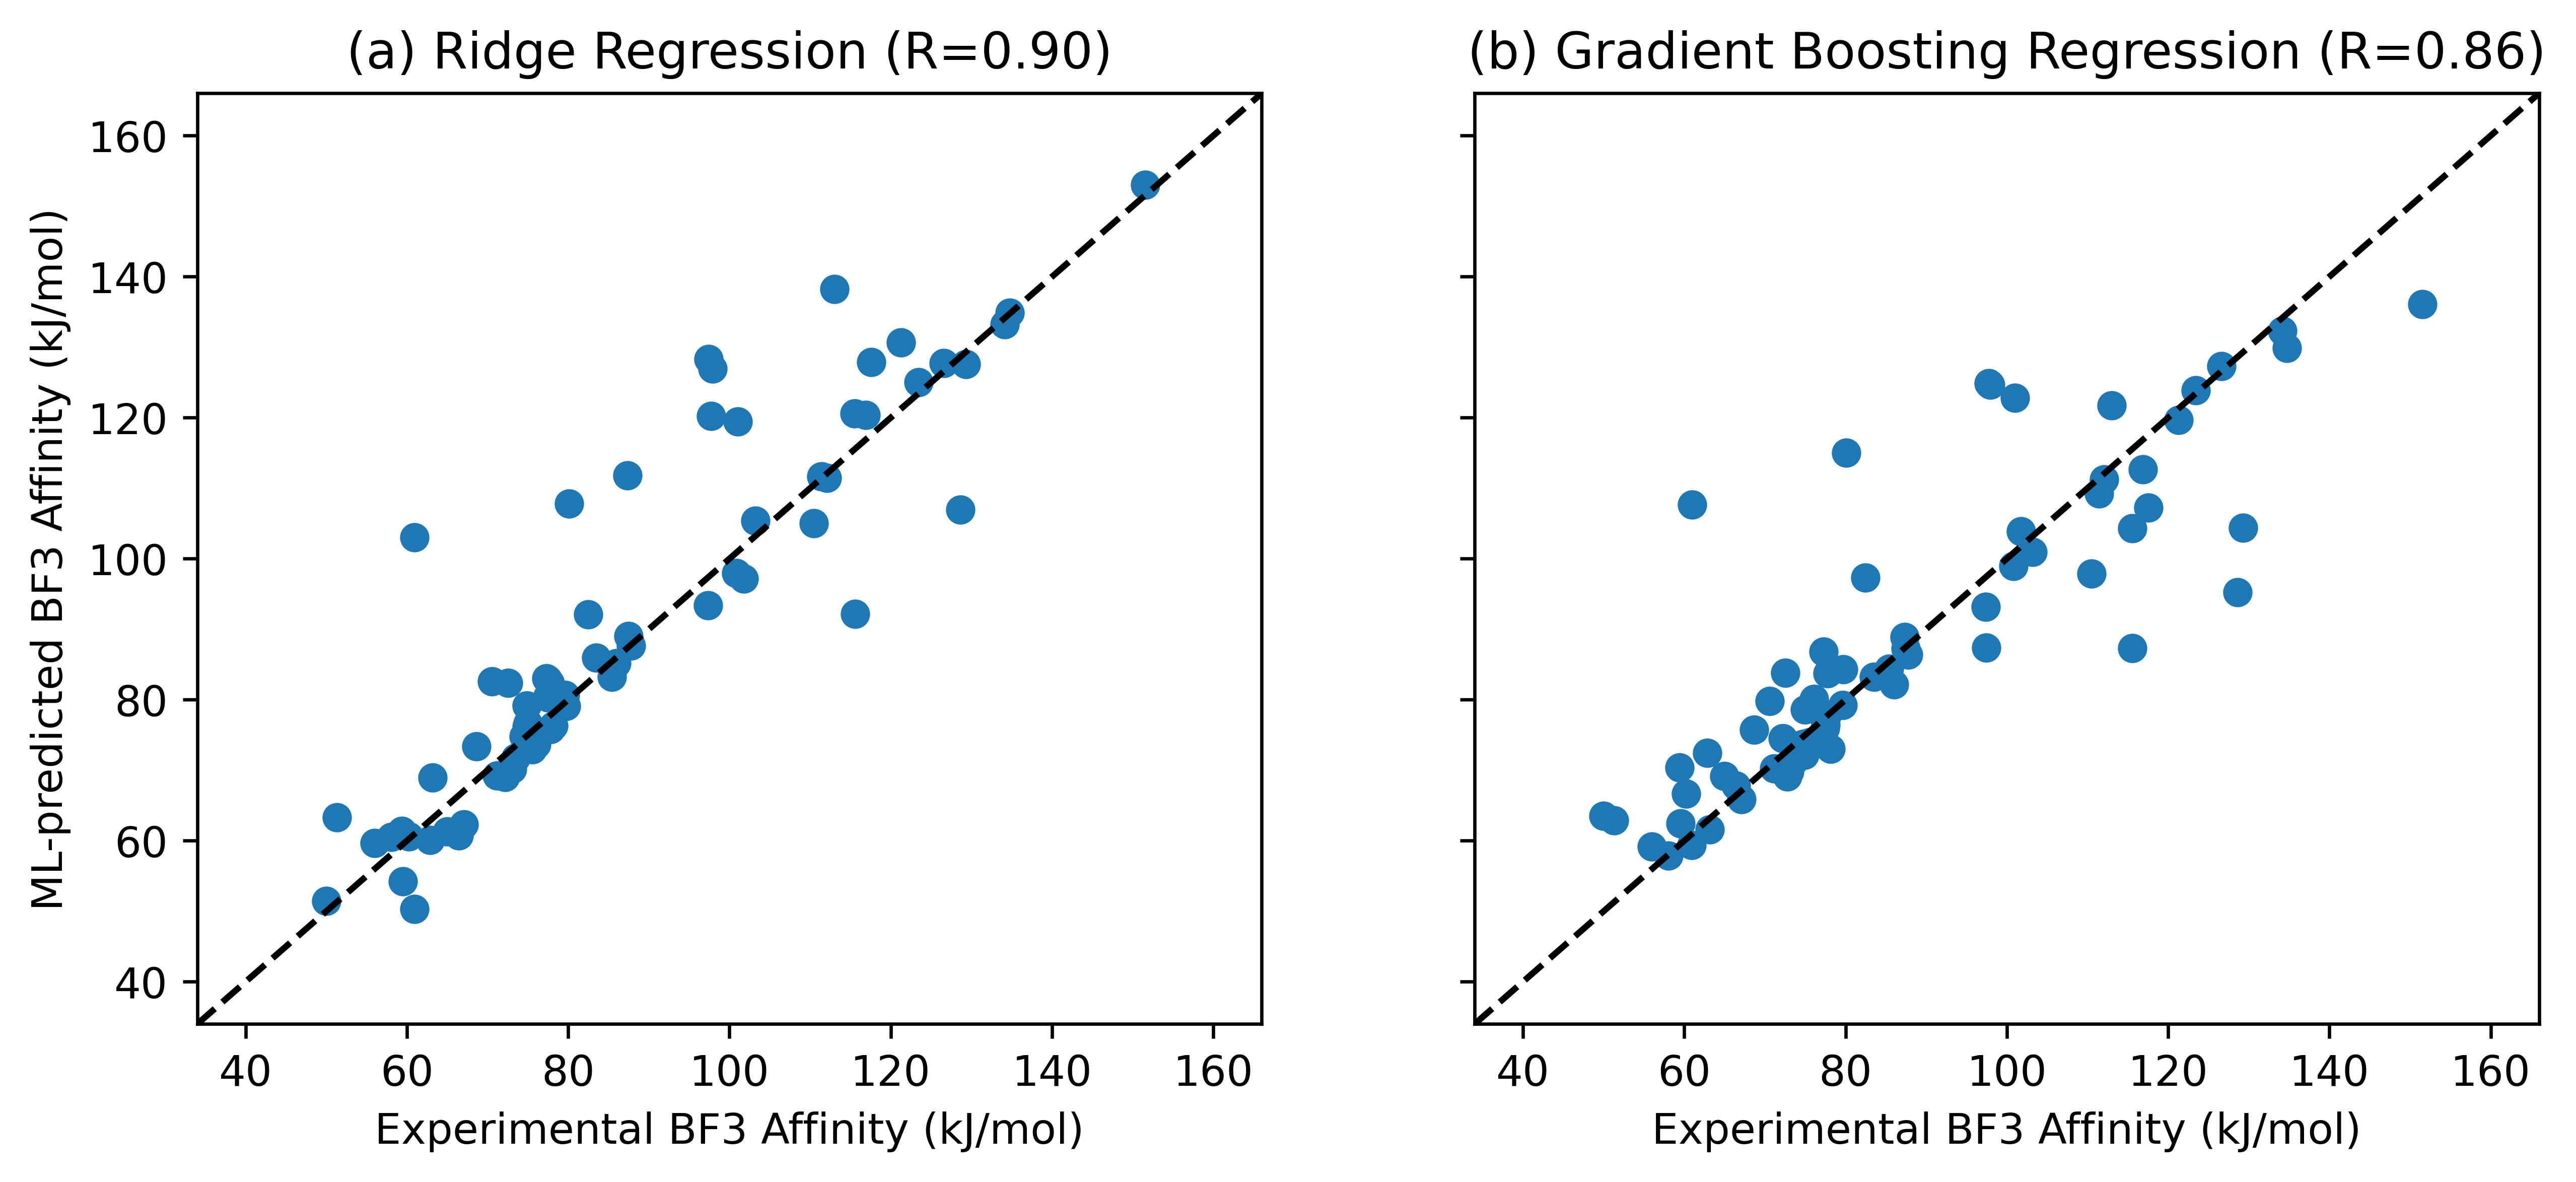

In [31]:
#Train Test Validation 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),dpi=600, sharey=True)
ax1.scatter(x=y_test,y=ridge_y_test_pred)
ax1.axline([40, 40], [160, 160], color="black", linestyle="--")
ax1.set_title('(a) Ridge Regression (R=0.90)')
ax1.set_xlabel('Experimental BF3 Affinity (kJ/mol)')
ax1.set_ylabel('ML-predicted BF3 Affinity (kJ/mol)')
ax2.scatter(x=y_test,y=gb_y_test_pred)
ax2.axline([40, 40], [160, 160], color="black", linestyle="--")
ax2.set_title('(b) Gradient Boosting Regression (R=0.86)')
ax2.set_xlabel('Experimental BF3 Affinity (kJ/mol)')
plt.show()

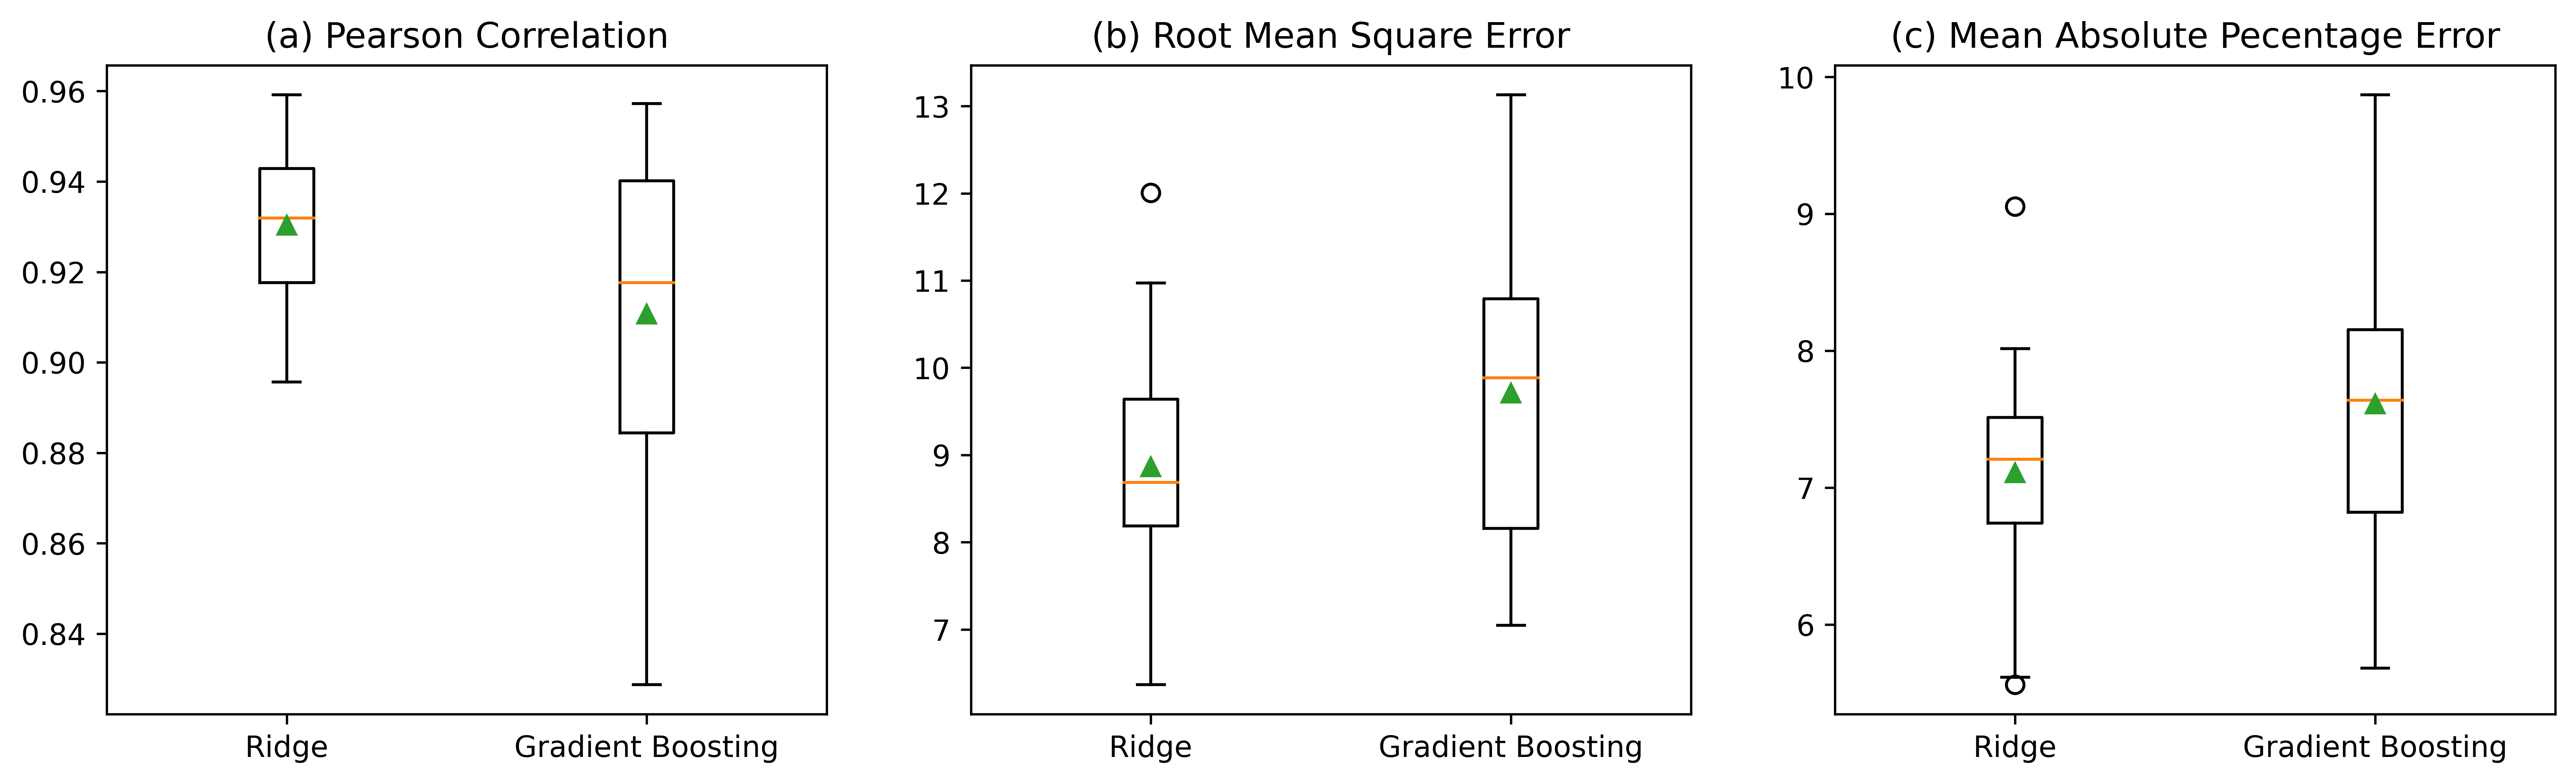

In [32]:
#Cross validation
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4),dpi=600, sharey=False)
ax1.boxplot([ridge_r,gb_r],labels=['Ridge','Gradient Boosting'],showmeans=True)
ax1.set_title('(a) Pearson Correlation')
ax2.boxplot([-ridge_rmse,-gb_rmse],labels=['Ridge','Gradient Boosting'],showmeans=True)
ax2.set_title('(b) Root Mean Square Error')
ax3.boxplot([ridge_mape,gb_mape],labels=['Ridge','Gradient Boosting'],showmeans=True)
ax3.set_title('(c) Mean Absolute Pecentage Error')
plt.show()